# TreeCorr Explorer 3 #
In this notebook, we make plots of clustering in different pz bins and magnitude bins. For magnitude bins, also plot the histogram of pz-distribution. 

In [1]:
from __future__ import print_function
from astropy.io import fits
import numpy as np
import pandas as pd
import treecorr
import time
import pprint
import matplotlib
from matplotlib import pyplot as plt
from astropy.table import Table
%matplotlib inline

In [2]:
plt.rcdefaults()
plt.rcParams.update({'figure.dpi':100})
plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })
plt.rc('legend',**{'fontsize':'x-small'})
#plt.figure(1,figsize = [11.0, 8.5])
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':'True'})
plt.rcParams.update({'ytick.right':'True'})
plt.rcParams.update({'axes.formatter.limits': (-2, 2)})
# My own adds to Carles' rcParams updates
#plt.rcParams.update({'lines.markersize': 8}) 6 is the default
plt.rcParams.update({'legend.framealpha': 1.0})
plt.rcParams.update({'legend.fancybox': 'False'})

## Defined functions ##

In [3]:
def label_generator(r):
    '''Given a list or array r, returns range labels in the form of list.
       The last item in r is ignored with the last item in labels being
       (the secong last item in r - )
    '''
    labels = []
    s = '{:0.1f}-{:0.1f}'
    for i in range(len(r)-1):
        if (i == len(r)-2):
            labels.append('{}-'.format(r[i]))
        else:
            labels.append(s.format(r[i], r[i+1]))
    return labels

In [4]:
gg = treecorr.GGCorrelation(min_sep=1, max_sep=400, 
                            nbins=15, sep_units='arcmin', var_method='jackknife')

In [5]:
dd = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [6]:
rr = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [7]:
dr = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [8]:
ng = treecorr.NGCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [9]:
def plot_gg(data, labels, figsize):
    ''' Takes in galaxy data and pz_labels to plot shear-shear correlation.
    data: pd dataframe
    labels: list
    figsize: list of two length elements
    '''
    figs, axes = plt.subplots(len(labels), 1, sharex=True, figsize = figsize)
    for i in range(len(labels)):
        mask = data.pz_group == labels[i]
        ra = data[mask].ira
        dec = data[mask].idec
        g1 = data[mask].ishape_hsm_regauss_e1
        g2 = data[mask].ishape_hsm_regauss_e2
        cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, npatch=10,
                              ra_units='degrees', dec_units='degrees')
        gg.process(cat)
        r = np.exp(gg.meanlogr)
        xip = gg.xip
        xim = gg.xim
        sig = np.sqrt(gg.varxip)
        
        axes[i].plot(r, xip, color='blue')
        axes[i].plot(r, -xip, color='blue', ls=':')
        axes[i].errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], color='blue', lw=0.1, ls='')
        axes[i].errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], color='blue', lw=0.1, ls='')
        lp = axes[i].errorbar(-r, xip, yerr=sig, color='blue')
        
        axes[i].plot(r, xim, color='green')
        axes[i].plot(r, -xim, color='green', ls=':')
        axes[i].errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
        axes[i].errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
        lm = axes[i].errorbar(-r, xim, yerr=sig, color='green')
        
        axes[i].set_xscale('log')
        axes[i].set_yscale('log', nonposy='clip')
        if (i == len(labels)-1):
            axes[i].set_xlabel(r'$\theta$ (arcmin)')
        axes[i].set_title('z={}'.format(labels[i]))
        axes[i].legend([lp, lm], [r'$\xi_+(\theta)$', r'$\xi_-(\theta)$'])
        axes[i].set_xlim( [1,200] )
        axes[i].set_ylabel(r'$\xi_{+,-}$')
        
    plt.show()

In [85]:
def plot_ng(data, labels, figsize):
    ''' 
    ng correlation needs a source and lens catalog of which 
    z_source > z_lens. Function returns a plot of gamma_t for the 
    respective lens and source bins.
    data: pd dataframe
    labels: list
    figsize: list of two length elements
    '''
    # Find out how to add a set of master axes for source and lens z
    n = len(labels)
    figs, axes = plt.subplots(n, n, sharex=False, figsize = figsize)
    # i iterate through z_source, row data
    # j iterate through z_lens, col data
    # Make sure that i and j iterate through the same things
    for i in range(n):
        smask = data.pz_group == labels[i]
        sra = data[smask].ira
        sdec = data[smask].idec
        sg1 = data[smask].ishape_hsm_regauss_e1
        sg2 = data[smask].ishape_hsm_regauss_e2
        sw = data[smask].ishape_hsm_regauss_derived_shape_weight
        scat = treecorr.Catalog(ra=sra, dec=sdec, g1=sg1, g2=sg2, w=sw, npatch=40, 
                                        ra_units='degrees', dec_units='degrees')
        for j in range(n):
            if (i > j):
                lmask = data.pz_group == labels[j]
                lra = data[lmask].ira
                ldec = data[lmask].idec
                lg1 = data[lmask].ishape_hsm_regauss_e1
                lg2 = data[lmask].ishape_hsm_regauss_e2
                lw = data[lmask].ishape_hsm_regauss_derived_shape_weight
                lcat = treecorr.Catalog(ra=lra, dec=ldec, g1=lg1, g2=lg2, w=lw, npatch=40,
                                        ra_units='degrees', dec_units='degrees')

                ng.process(lcat, scat)
                r = np.exp(ng.meanlogr)
                xip = ng.xi
                xim = ng.xi_im
                sig = np.sqrt(ng.varxi)

                axes[i, j].scatter(r, xip, color='blue')
                axes[i, j].scatter(r, -xip, color='lightblue', ls=':')
                axes[i, j].errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], 
                                    color='blue', lw=0.1, ls='')
                axes[i, j].errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], 
                                    color='blue', lw=0.1, ls='')
                lp = axes[i, j].errorbar(-r, xip, yerr=sig, color='blue')

                #axes[i, j].plot(r, xim, color='green')
                #axes[i, j].plot(r, -xim, color='green', ls=':')
                #axes[i, j].errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
                #axes[i, j].errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
                #lm = axes[i, j].errorbar(-r, xim, yerr=sig, color='green')
        
                axes[i, j].set_xscale('log')
                axes[i, j].set_yscale('log', nonposy='clip')
                #if (i == len(labels)-1):
                #    axes[i].set_xlabel(r'$\theta$ (arcmin)')
                axes[i, j].set_title(r'$z_s:{}$, $z_l:{}$'.format(labels[i], labels[j]))
                axes[i, j].legend([lp], [r'$\xi_{Re}(\theta)$'])
                #axes[i, j].set_xlim( [1, 50] )
                axes[i, j].set_xlabel(r'$\theta$ (arcmin)')
                axes[i, j].set_ylabel(r'$\xi_{Re}$')
            else:
                axes[i, j].set_axis_off()
        
    plt.show()

In [54]:
def plot_dr_pz(data, random, labels, figsize):
    ''' Takes in galaxy data, random catalog and pz_labels to plot 
        data-random correlation in pz_bins.
        data: pd dataframe
        random: pd dataframe
        labels: list
        figsize: list of two length elements
    '''
    figs, axes = plt.subplots(1, 1, sharex=True, figsize = figsize)
    for i in range(len(labels)):
        mask = data.pz_group == labels[i]        
        cra = data[mask].ira
        cdec = data[mask].idec
        cg1 = data[mask].ishape_hsm_regauss_e1
        cg2 = data[mask].ishape_hsm_regauss_e2
        cw = data[mask].ishape_hsm_regauss_derived_shape_weight        
        cat = treecorr.Catalog(ra=cra, dec=cdec, g1=cg1, g2=cg2, w=cw, npatch=10,
                              ra_units='degrees', dec_units='degrees')
        
        rra = random.ra
        rdec = random.dec       
        rand = treecorr.Catalog(ra=rra, dec=rdec, npatch=10, 
                                ra_units='degrees', dec_units='degrees')
        
        dd.process(cat)
        rr.process(rand)
        dr.process(cat, rand)
        xi, varxi = dd.calculateXi(rr, dr)
        r = np.exp(dd.meanlogr)
        sig = np.sqrt(varxi)
        
        axes.plot(r, xi, color=colorwheel[i], label='pz:{}'.format(labels[i]))
        axes.plot(r, -xi, color=colorwheel[i], ls=':')
        axes.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes.errorbar(-r, xi, yerr=sig, color=colorwheel[i])
        
    axes.set_title('Clustering in pz bins')    
    axes.set_xscale('log')
    axes.set_yscale('log', nonposy='clip')
    axes.set_xlabel(r'$\theta$ (arcmin)')
    axes.legend()
        
    plt.show()

In [75]:
def plot_dr_mag(data, random, pz, labels, figsize, pz_bins):
    ''' Takes in galaxy data, random, pz catalog and mag_labels to plot 
        data-random correlation in i-mag bins.
        data: pd dataframe
        random: pd dataframe
        pz: pd dataframe
        labels: list
        figsize: list of two length elements
        pz_bins: int of the number of bins for pz histogram
    '''
    figs, axes = plt.subplots(1, 2, figsize = figsize)
    # Initiate two subplots where one is the clustering signal and the other
    # is the histogram of pz for rhe respective imag bin galaxies
    for i in range(len(labels)):
        mask = data.mag_group == labels[i]
        
        # Catalog data
        cra = data[mask].ira
        cdec = data[mask].idec
        cg1 = data[mask].ishape_hsm_regauss_e1
        cg2 = data[mask].ishape_hsm_regauss_e2
        cw = data[mask].ishape_hsm_regauss_derived_shape_weight
        cat = treecorr.Catalog(ra=cra, dec=cdec, g1=cg1, g2=cg2, w=cw, npatch=40,
                              ra_units='degrees', dec_units='degrees')
        
        # Random catalog data
        rra = random.ra
        rdec = random.dec       
        rand = treecorr.Catalog(ra=rra, dec=rdec, npatch=40, 
                                ra_units='degrees', dec_units='degrees')
        
        # Pz catalog data 
        photoz = pz[mask].ephor_photoz_best
        
        # Processing the catalogs
        dd.process(cat)
        rr.process(rand)
        dr.process(cat, rand)
        xi, varxi = dd.calculateXi(rr, dr)
        r = np.exp(dd.meanlogr)
        sig = np.sqrt(varxi)
        
        # Ploting clustering signal of different mag bins on 0-th subplot
        axes[0].plot(r, xi, color=colorwheel[i], label='i-mag:{}'.format(labels[i]))
        axes[0].plot(r, -xi, color=colorwheel[i], ls=':')
        axes[0].errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes[0].errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes[0].errorbar(-r, xi, yerr=sig, color=colorwheel[i])
        
        # Plotting pz histogram of different mag bins on 1-th subplot 
        # using the same color scheme
        axes[1].hist(photoz, bins=pz_bins, histtype='step', linewidth=1, 
                     color=colorwheel[i], label='Total:{}'.format(len(data[mask])))
        
    axes[0].set_title('Clustering in imag bins')    
    axes[0].set_xscale('log')
    axes[0].set_yscale('log', nonposy='clip')
    axes[0].set_xlabel(r'$\theta$ (arcmin)')
    axes[0].legend(loc='lower left')
    
    axes[1].set_title('pz distribution for imag bins')
    axes[1].set_xlabel('ephor best pz')
    axes[1].set_ylabel('Number of galaxies')
    axes[1].set_yscale('log')
    axes[1].legend()
        
    plt.show()

In [14]:
colorwheel = ['blue', 'red', 'green', 'orange', 'teal', 'purple', 'cyan']

## Plot clustering in pz bins and i-mag bins ##

### Import data ###

In [12]:
hectomap_path = "Data/HECTOMAP_calibrated.fits"
hectomap_pz_path = "Data/HECTOMAP_pz.fits"
hectomap_rand_path = "Data/HECTOMAP_rand.fits"

In [13]:
df = Table.read(hectomap_path, format='fits').to_pandas()
pz_df = Table.read(hectomap_pz_path, format='fits').to_pandas()
rand_df = Table.read(hectomap_rand_path, format='fits').to_pandas()

### Separate into bins ###

In [15]:
pz_range = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, 100])
pz_labels = label_generator(pz_range)

In [16]:
df['pz_group'] = pd.cut(pz_df.ephor_photoz_best, pz_range, right=False, labels=pz_labels)

In [68]:
mag_range = np.array([17, 18, 19, 20, 21, 22, 23, 100])
mag_labels = label_generator(mag_range)

In [69]:
df['mag_group'] = pd.cut(df.imag_cmodel, mag_range, right=False, labels=mag_labels)

### Enforce i-band magnitude cut ###

In [79]:
imag_mask = df.imag_cmodel <= 23
df_imag_masked = df[imag_mask]
pz_df_imag_masked = pz_df[imag_mask]

In [80]:
pz_mask = pz_df_imag_masked.ephor_photoz_best <= 1.5
df_imag_pz_masked = df_imag_masked[pz_mask]
pz_df_imag_pz_masked = pz_df_imag_masked[pz_mask]

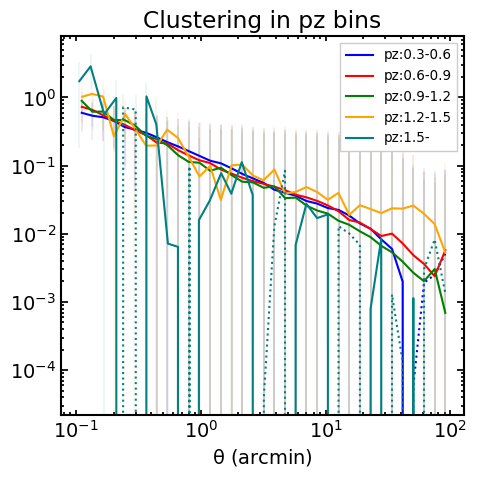

In [42]:
plot_dr_pz(df_imag_masked, rand_df, pz_labels[1:], [5, 5])

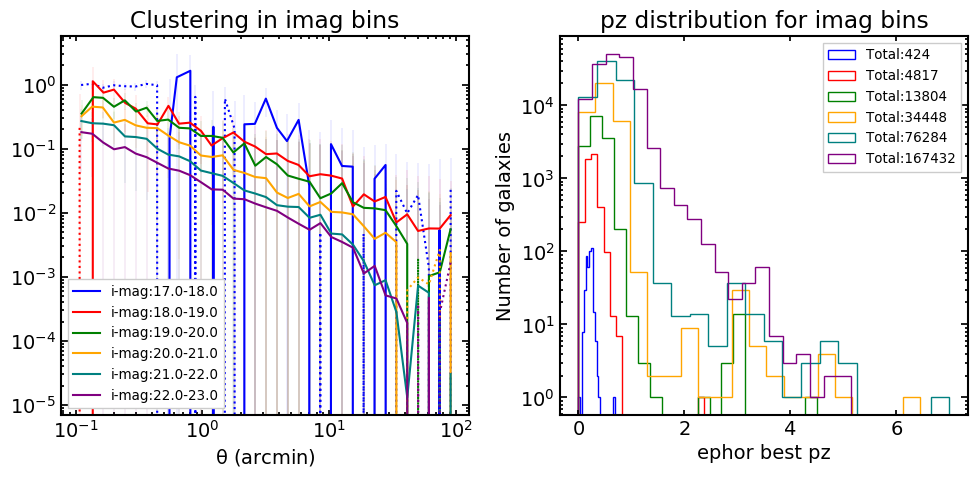

In [76]:
plot_dr_mag(df_imag_masked, rand_df, pz_df_imag_masked, mag_labels[:-1], [10, 5], 20)

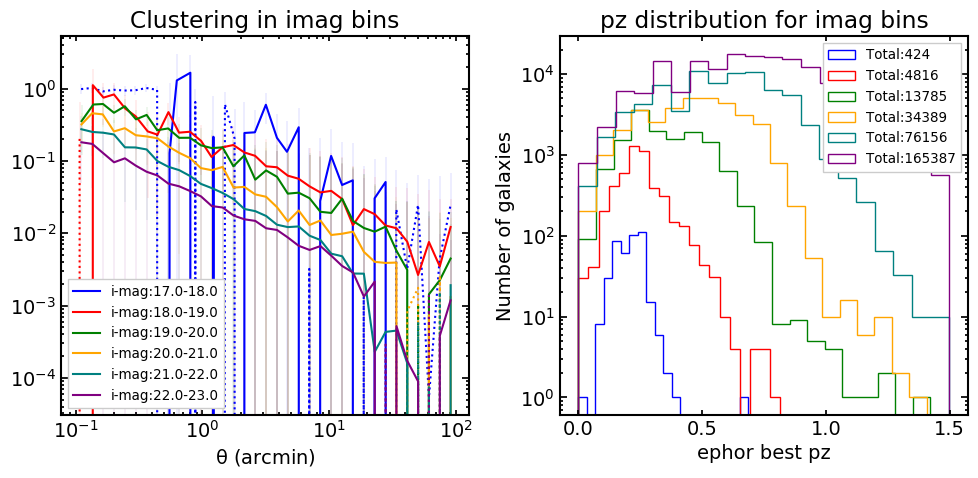

In [81]:
plot_dr_mag(df_imag_pz_masked, rand_df, pz_df_imag_pz_masked, mag_labels[:-1], [10, 5], 20)

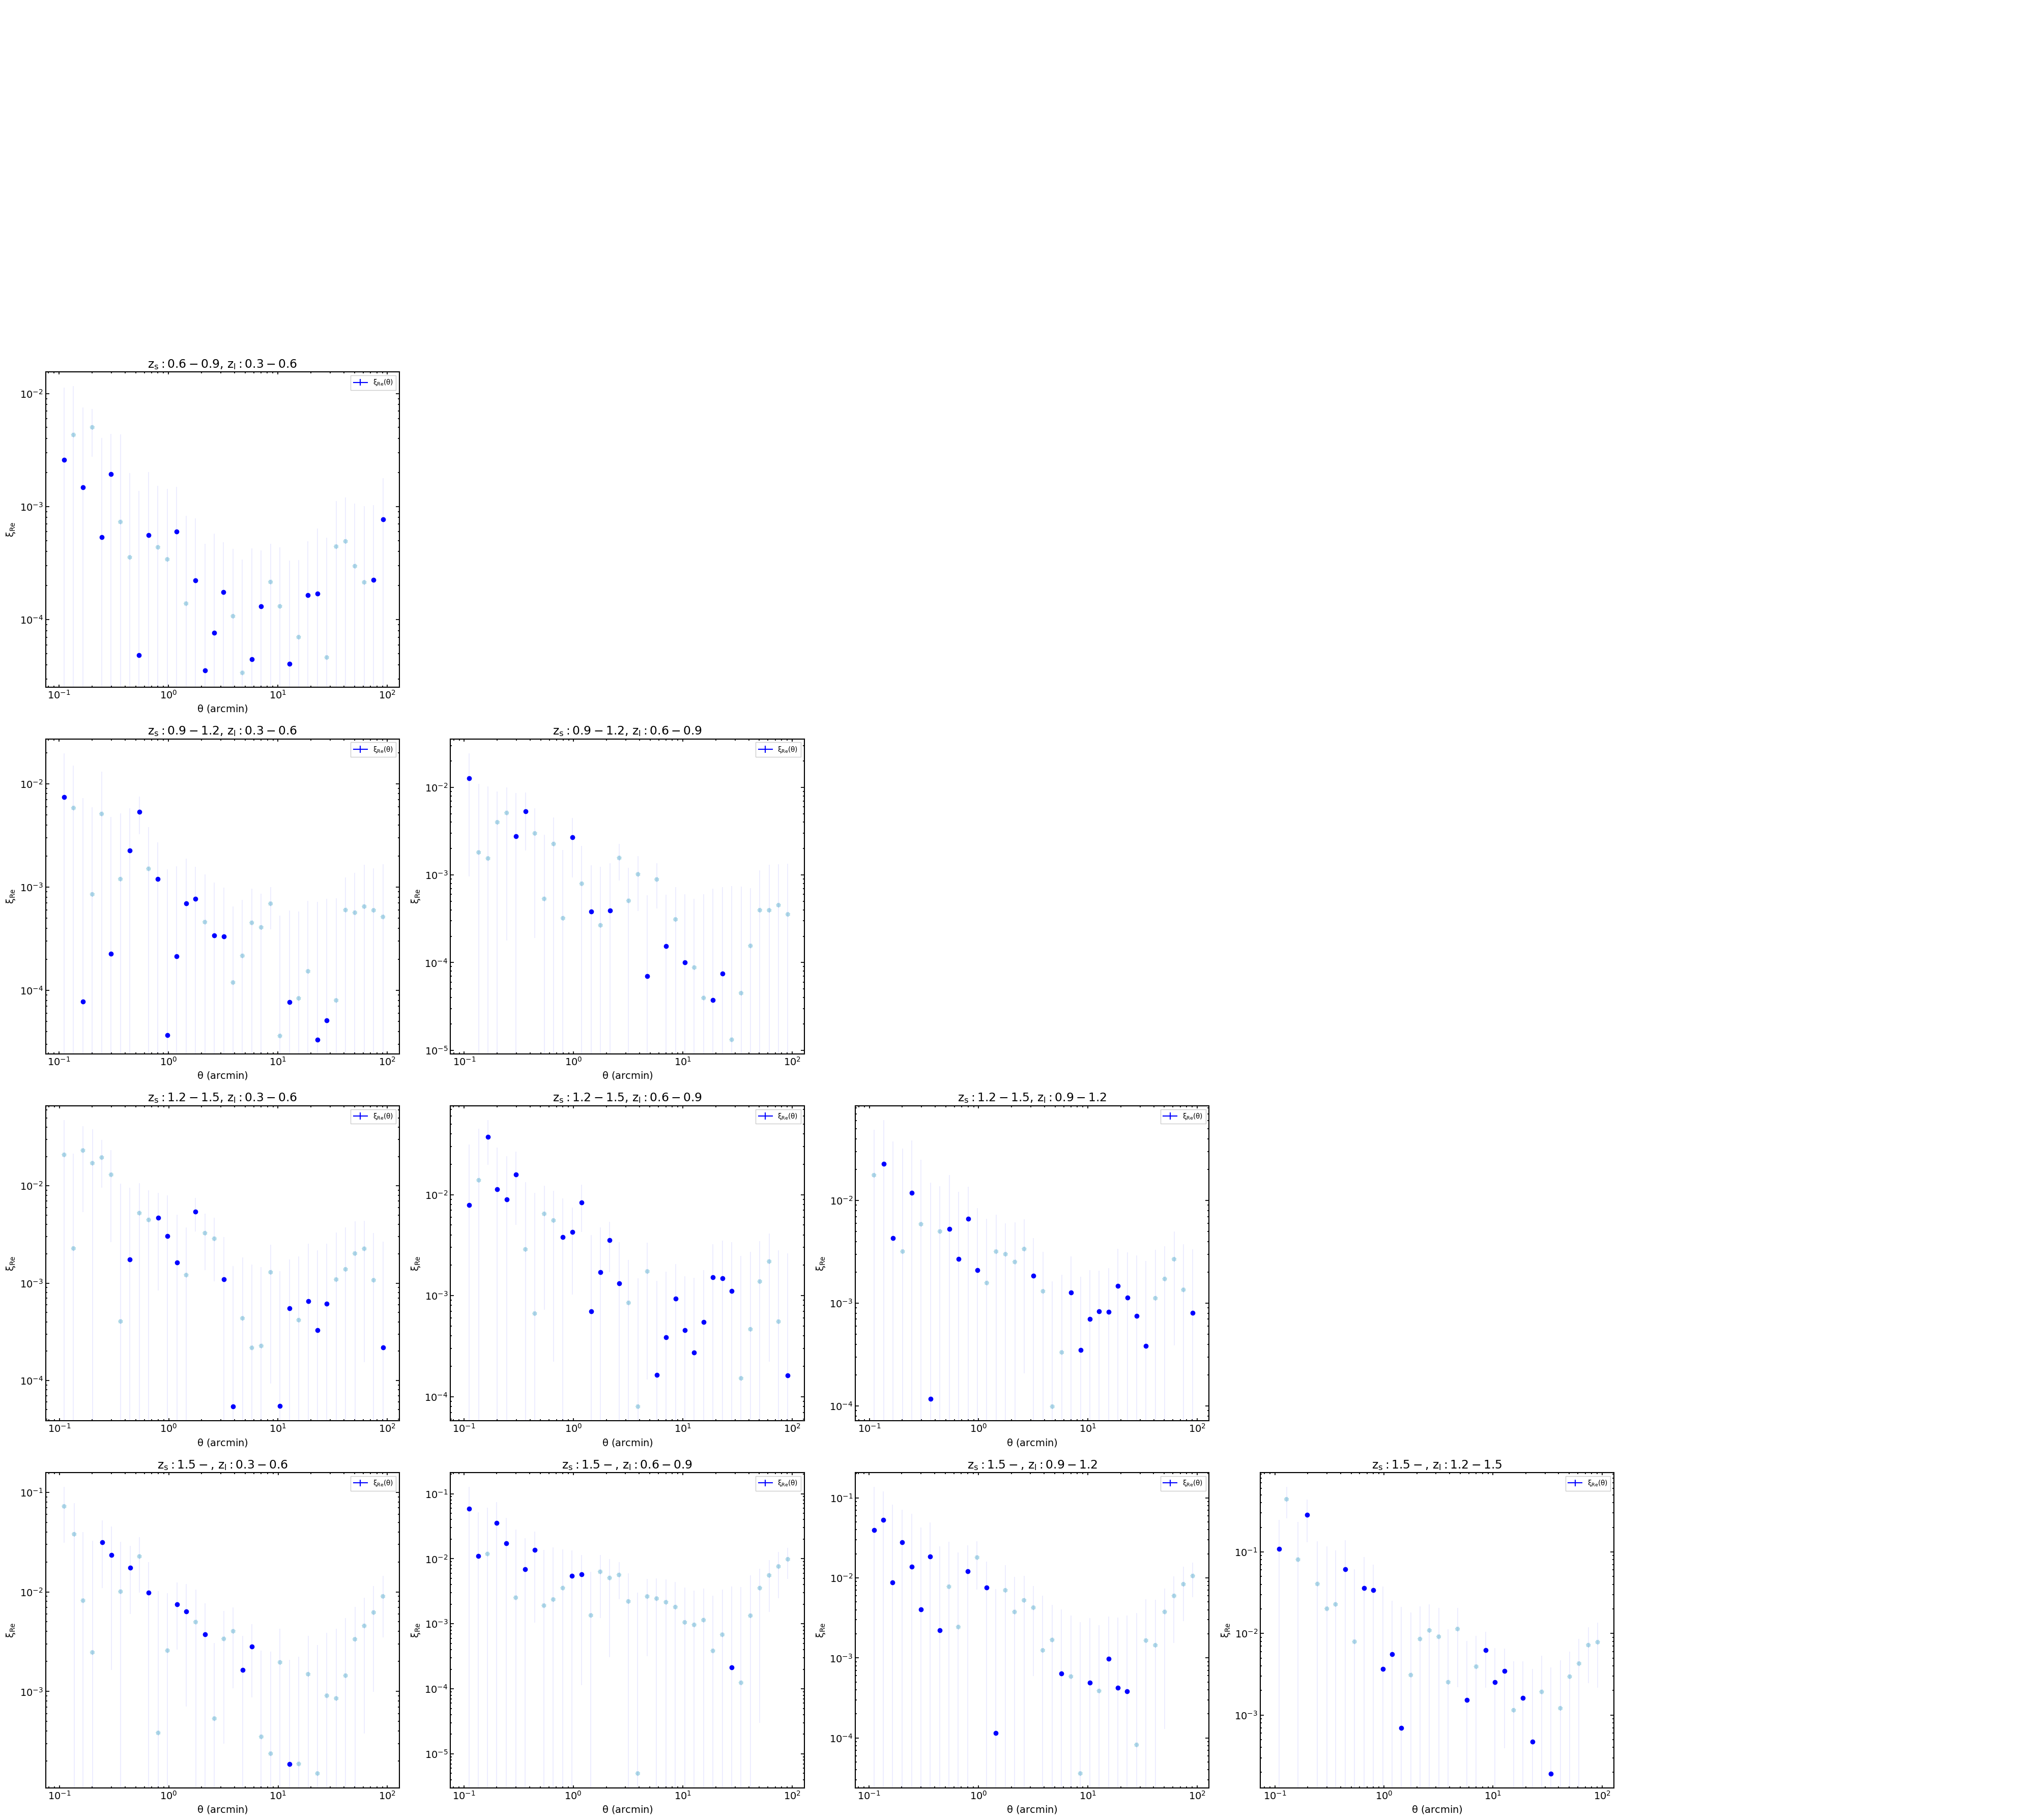

In [89]:
plot_ng(df_imag_masked, pz_labels[1:], [40, 36])

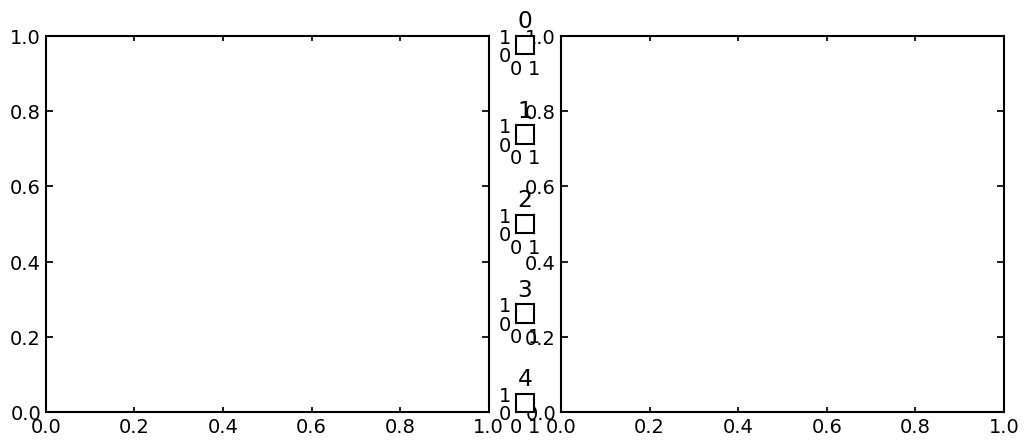

In [53]:
f, a = plt.subplots(1, 2, figsize = (10, 5))
for i in range(5):
    axis = f.add_subplot((5*100)+(1*10)+(1+i))
    axis.set_title('{}'.format(i))
    axis.set_aspect('equal')
plt.show()

In [56]:
mask = df_imag_masked.mag_group == mag_labels[1]
pz_df_imag_masked[mask]

,object_id,ephor_photoz_mean,ephor_photoz_mode,ephor_photoz_median,ephor_photoz_best,ephor_photoz_mc,ephor_photoz_conf_mean,ephor_photoz_conf_mode,ephor_photoz_conf_median,ephor_photoz_conf_best,...,mlz_photoz_risk_best,mlz_photoz_std_mean,mlz_photoz_std_mode,mlz_photoz_std_median,mlz_photoz_std_best,mlz_photoz_err68_min,mlz_photoz_err68_max,mlz_photoz_err95_min,mlz_photoz_err95_max,mlz_flux_binary_flag
16,69607899311120680,0.294572,0.297081,0.295287,0.292437,0.323209,0.812368,0.805624,0.810445,0.818108,...,0.066468,0.057450,0.064376,0.058227,0.058158,0.282784,0.404837,0.246881,0.461288,1023
26,69607899311121570,0.324964,0.310832,0.318475,0.322411,0.298467,0.730023,0.746121,0.755702,0.740127,...,0.037048,0.040597,0.040822,0.040597,0.040999,0.303989,0.387489,0.267326,0.424443,1023
70,69607899311140696,0.277909,0.297919,0.275919,0.247406,0.303257,0.320146,0.353824,0.310087,0.227682,...,0.221426,0.128087,0.129300,0.128186,0.129300,0.243679,0.536336,0.164228,0.623774,1023
90,69607899311141368,0.298797,0.301100,0.304932,0.310888,0.336542,0.636702,0.639158,0.643246,0.649599,...,0.113895,0.073253,0.085497,0.074650,0.073367,0.200661,0.359160,0.135781,0.400283,1023
95,69607899311141447,0.661076,0.656553,0.658973,0.659904,0.690284,0.835268,0.815295,0.825981,0.830090,...,0.097716,0.091675,0.095408,0.092332,0.091900,0.556020,0.720403,0.365003,0.773931,1023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984408,70418247970744209,0.562052,0.562546,0.565812,0.568127,0.575549,0.812899,0.816516,0.840451,0.857411,...,0.171522,0.119188,0.128552,0.120350,0.119467,0.419209,0.662531,0.283210,0.726046,1023
984412,70418247970744302,0.529505,0.532307,0.530383,0.528169,0.528899,0.885246,0.863170,0.878328,0.886067,...,0.032964,0.044550,0.045953,0.044686,0.044568,0.515816,0.609402,0.483416,0.652195,1023
984414,70418247970744319,0.584912,0.587466,0.585831,0.583282,0.535381,0.792952,0.780092,0.788326,0.801162,...,0.103595,0.088033,0.106704,0.088577,0.088033,0.531229,0.718536,0.450134,0.778341,1023
984460,70418247970745471,0.543915,0.550955,0.550642,0.550408,0.428022,0.804244,0.811429,0.811110,0.810870,...,0.108712,0.089627,0.091464,0.089961,0.089644,0.474090,0.654398,0.365746,0.704044,1023


In [61]:
mag_labels

['17.0-19.0', '19.0-21.0', '21.0-23.0', '23-']